In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend as K

import requests

In [116]:

urlPost = "https://marketdata.websol.barchart.com/getHistory.csv?apikey=958bd129b997922724b5242bdcc8cf9d&symbol=IBM&type=minutes&startDate=20200101&endDate=20200201&interval=60&order=asc&sessionFilter=EFK&splits=true÷nds=true&volume=sum&nearby=1&jerq=true"

myobj = {
    'apikey':'958bd129b997922724b5242bdcc8cf9d',
}

x = requests.post(urlPost, data = myobj)

f = open("dataset2.csv", "w")
f.write(x.text)
f.close()

In [ ]:
urlPost = "https://marketdata.websol.barchart.com/getHistory.csv"

In [100]:
dataframe = pd.read_csv("dataset.csv") 

In [101]:
dataframe[0:5]

,symbol,timestamp,tradingDay,open,high,low,close,volume
0,IBM,2020-04-30T09:00:00-04:00,2020-04-30,124.8457,125.1516,123.5629,125.0184,630923
1,IBM,2020-04-30T10:00:00-04:00,2020-04-30,125.0233,125.5857,123.9773,124.4411,618914
2,IBM,2020-04-30T11:00:00-04:00,2020-04-30,124.4608,125.0134,124.0661,124.1944,504043
3,IBM,2020-04-30T12:00:00-04:00,2020-04-30,124.1747,124.6286,123.6320,124.4806,465759
4,IBM,2020-04-30T13:00:00-04:00,2020-04-30,124.4310,124.4891,123.8836,124.0069,321820


In [102]:
dataframe.describe()

,open,high,low,close,volume
count,140.000000,140.000000,140.000000,140.000000,1.400000e+02
mean,121.007309,121.468799,120.482169,120.947014,4.330178e+05
std,2.828653,2.754608,2.824377,2.796046,1.860959e+05
min,112.430000,114.320000,111.810000,112.440000,1.674290e+05
25%,119.755000,120.117500,119.174900,119.347375,2.900125e+05
50%,121.515000,121.925000,121.058250,121.472500,3.870425e+05
75%,122.413950,122.812500,121.902500,122.380875,5.377115e+05
max,126.870000,126.970000,125.495000,125.880000,1.153210e+06


In [103]:
dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"]).values.astype(np.int64) 
dataframe = dataframe.drop(["tradingDay"], axis=1)

dataframe['symbol'] = pd.factorize(dataframe['symbol'])[0] + 1


In [104]:
dataframe[0:5]

,symbol,timestamp,open,high,low,close,volume
0,1,1588251600000000000,124.8457,125.1516,123.5629,125.0184,630923
1,1,1588255200000000000,125.0233,125.5857,123.9773,124.4411,618914
2,1,1588258800000000000,124.4608,125.0134,124.0661,124.1944,504043
3,1,1588262400000000000,124.1747,124.6286,123.6320,124.4806,465759
4,1,1588266000000000000,124.4310,124.4891,123.8836,124.0069,321820


In [50]:
dataframe.describe()

,symbol,timestamp,open,high,low,close,volume
count,154.0,1.540000e+02,154.000000,154.000000,154.000000,154.000000,1.540000e+02
mean,1.0,1.589338e+18,121.465147,121.934795,120.932926,121.397802,4.367710e+05
std,0.0,7.922156e+14,3.078755,3.023452,3.065841,3.042789,1.885894e+05
min,1.0,1.588079e+18,112.430000,114.320000,111.810000,112.440000,1.674290e+05
25%,1.0,1.588695e+18,119.957500,120.425000,119.742500,119.994925,3.000700e+05
50%,1.0,1.589342e+18,121.629350,122.155950,121.241900,121.589850,3.870425e+05
75%,1.0,1.589990e+18,123.242500,123.845675,122.915000,123.257500,5.421845e+05
max,1.0,1.590692e+18,127.174400,127.598700,126.735300,127.174400,1.153210e+06


In [61]:
X = dataframe.drop(["close"], axis=1)
y = dataframe["close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
nEpocas = 1000
steps_per_epoch = 10
VALIDATION_SIZE = 1
BATCH_SIZE = 16
checkpoint = "bestModelTextGen.hdf5"

In [118]:
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

model = Sequential()

model.add(Embedding(output_dim=64, input_dim=len (X.columns) ))

model.add(LSTM(32, return_sequences=True))

model.add(Dropout(0.5))

model.add(LSTM(32, return_sequences=False))

model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['mse', 'mae', 'mape', 'cosine'])

mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)

# fit the model
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

#batch_size = numero de execuções antes de atualizar os erros.
history = model.fit( X_train, y_train, epochs=nEpocas, steps_per_epoch=steps_per_epoch, callbacks=[es, mc], validation_steps = val_steps, validation_data=(X_test, y_test))


Train on 103 samples, validate on 51 samples
Epoch 1/1000
10/10 [==============================] - 3s 304ms/step - loss: 121.3714 - mean_squared_error: 14739.0257 - mean_absolute_error: 121.3714 - mean_absolute_percentage_error: 99.9615 - cosine_proximity: -0.9049 - val_loss: 121.2382 - val_mean_squared_error: 14710.2939 - val_mean_absolute_error: 121.2382 - val_mean_absolute_percentage_error: 99.9022 - val_cosine_proximity: -1.0000

Epoch 00001: loss improved from inf to 121.37137, saving model to bestModelTextGen.hdf5
Epoch 2/1000
10/10 [==============================] - 0s 16ms/step - loss: 121.1909 - mean_squared_error: 14695.2476 - mean_absolute_error: 121.1909 - mean_absolute_percentage_error: 99.8127 - cosine_proximity: -1.0000 - val_loss: 120.9404 - val_mean_squared_error: 14638.1553 - val_mean_absolute_error: 120.9404 - val_mean_absolute_percentage_error: 99.6565 - val_cosine_proximity: -1.0000

Epoch 00002: loss improved from 121.37137 to 121.19085, saving model to bestModelT


Epoch 00017: loss improved from 108.43470 to 108.05392, saving model to bestModelTextGen.hdf5
Epoch 18/1000
10/10 [==============================] - 0s 15ms/step - loss: 107.6768 - mean_squared_error: 11602.3186 - mean_absolute_error: 107.6768 - mean_absolute_percentage_error: 88.6765 - cosine_proximity: -1.0000 - val_loss: 107.4090 - val_mean_squared_error: 11548.2725 - val_mean_absolute_error: 107.4090 - val_mean_absolute_percentage_error: 88.4975 - val_cosine_proximity: -1.0000

Epoch 00018: loss improved from 108.05392 to 107.67679, saving model to bestModelTextGen.hdf5
Epoch 19/1000
10/10 [==============================] - 0s 16ms/step - loss: 107.3034 - mean_squared_error: 11522.0455 - mean_absolute_error: 107.3034 - mean_absolute_percentage_error: 88.3688 - cosine_proximity: -1.0000 - val_loss: 107.0372 - val_mean_squared_error: 11468.5469 - val_mean_absolute_error: 107.0372 - val_mean_absolute_percentage_error: 88.1909 - val_cosine_proximity: -1.0000

Epoch 00019: loss improve


Epoch 00034: loss improved from 102.28089 to 101.93097, saving model to bestModelTextGen.hdf5
Epoch 35/1000
10/10 [==============================] - 0s 15ms/step - loss: 101.5816 - mean_squared_error: 10326.8535 - mean_absolute_error: 101.5816 - mean_absolute_percentage_error: 83.6537 - cosine_proximity: -1.0000 - val_loss: 101.3282 - val_mean_squared_error: 10278.9834 - val_mean_absolute_error: 101.3282 - val_mean_absolute_percentage_error: 83.4828 - val_cosine_proximity: -1.0000

Epoch 00035: loss improved from 101.93097 to 101.58163, saving model to bestModelTextGen.hdf5
Epoch 36/1000
10/10 [==============================] - 0s 15ms/step - loss: 101.2333 - mean_squared_error: 10256.2071 - mean_absolute_error: 101.2333 - mean_absolute_percentage_error: 83.3667 - cosine_proximity: -1.0000 - val_loss: 100.9801 - val_mean_squared_error: 10208.5664 - val_mean_absolute_error: 100.9801 - val_mean_absolute_percentage_error: 83.1958 - val_cosine_proximity: -1.0000

Epoch 00036: loss improve

Epoch 52/1000
10/10 [==============================] - 0s 15ms/step - loss: 95.7269 - mean_squared_error: 9171.6648 - mean_absolute_error: 95.7269 - mean_absolute_percentage_error: 78.8292 - cosine_proximity: -1.0000 - val_loss: 95.4776 - val_mean_squared_error: 9127.5664 - val_mean_absolute_error: 95.4776 - val_mean_absolute_percentage_error: 78.6580 - val_cosine_proximity: -1.0000

Epoch 00052: loss improved from 96.06821 to 95.72690, saving model to bestModelTextGen.hdf5
Epoch 53/1000
10/10 [==============================] - 0s 15ms/step - loss: 95.3860 - mean_squared_error: 9106.5149 - mean_absolute_error: 95.3860 - mean_absolute_percentage_error: 78.5482 - cosine_proximity: -1.0000 - val_loss: 95.1368 - val_mean_squared_error: 9062.5996 - val_mean_absolute_error: 95.1368 - val_mean_absolute_percentage_error: 78.3769 - val_cosine_proximity: -1.0000

Epoch 00053: loss improved from 95.72690 to 95.38601, saving model to bestModelTextGen.hdf5
Epoch 54/1000
10/10 [=====================

10/10 [==============================] - 0s 15ms/step - loss: 89.9617 - mean_squared_error: 8101.1297 - mean_absolute_error: 89.9617 - mean_absolute_percentage_error: 74.0783 - cosine_proximity: -1.0000 - val_loss: 89.7145 - val_mean_squared_error: 8060.2808 - val_mean_absolute_error: 89.7145 - val_mean_absolute_percentage_error: 73.9053 - val_cosine_proximity: -1.0000

Epoch 00069: loss improved from 90.29931 to 89.96169, saving model to bestModelTextGen.hdf5
Epoch 70/1000
10/10 [==============================] - 0s 15ms/step - loss: 89.6244 - mean_squared_error: 8040.5625 - mean_absolute_error: 89.6244 - mean_absolute_percentage_error: 73.8004 - cosine_proximity: -1.0000 - val_loss: 89.3772 - val_mean_squared_error: 7999.8662 - val_mean_absolute_error: 89.3772 - val_mean_absolute_percentage_error: 73.6271 - val_cosine_proximity: -1.0000

Epoch 00070: loss improved from 89.96169 to 89.62443, saving model to bestModelTextGen.hdf5
Epoch 71/1000
10/10 [==============================] - 0

10/10 [==============================] - 0s 17ms/step - loss: 84.2433 - mean_squared_error: 7104.9572 - mean_absolute_error: 84.2433 - mean_absolute_percentage_error: 69.3661 - cosine_proximity: -1.0000 - val_loss: 83.9972 - val_mean_squared_error: 7067.1211 - val_mean_absolute_error: 83.9972 - val_mean_absolute_percentage_error: 69.1904 - val_cosine_proximity: -1.0000

Epoch 00086: loss improved from 84.57867 to 84.24329, saving model to bestModelTextGen.hdf5
Epoch 87/1000
10/10 [==============================] - 0s 16ms/step - loss: 83.9079 - mean_squared_error: 7048.5581 - mean_absolute_error: 83.9079 - mean_absolute_percentage_error: 69.0897 - cosine_proximity: -1.0000 - val_loss: 83.6619 - val_mean_squared_error: 7010.9009 - val_mean_absolute_error: 83.6619 - val_mean_absolute_percentage_error: 68.9139 - val_cosine_proximity: -1.0000

Epoch 00087: loss improved from 84.24329 to 83.90789, saving model to bestModelTextGen.hdf5
Epoch 88/1000
10/10 [==============================] - 0

10/10 [==============================] - 0s 17ms/step - loss: 78.5532 - mean_squared_error: 6178.6263 - mean_absolute_error: 78.5532 - mean_absolute_percentage_error: 64.6771 - cosine_proximity: -1.0000 - val_loss: 78.3079 - val_mean_squared_error: 6143.7100 - val_mean_absolute_error: 78.3079 - val_mean_absolute_percentage_error: 64.4985 - val_cosine_proximity: -1.0000

Epoch 00103: loss improved from 78.88727 to 78.55318, saving model to bestModelTextGen.hdf5
Epoch 104/1000
10/10 [==============================] - 0s 16ms/step - loss: 78.2190 - mean_squared_error: 6126.2379 - mean_absolute_error: 78.2190 - mean_absolute_percentage_error: 64.4017 - cosine_proximity: -1.0000 - val_loss: 77.9739 - val_mean_squared_error: 6091.5073 - val_mean_absolute_error: 77.9739 - val_mean_absolute_percentage_error: 64.2231 - val_cosine_proximity: -1.0000

Epoch 00104: loss improved from 78.55318 to 78.21901, saving model to bestModelTextGen.hdf5
Epoch 105/1000
10/10 [==============================] -

10/10 [==============================] - 0s 16ms/step - loss: 72.8819 - mean_squared_error: 5319.8022 - mean_absolute_error: 72.8819 - mean_absolute_percentage_error: 60.0037 - cosine_proximity: -1.0000 - val_loss: 72.6372 - val_mean_squared_error: 5287.7451 - val_mean_absolute_error: 72.6372 - val_mean_absolute_percentage_error: 59.8220 - val_cosine_proximity: -1.0000

Epoch 00120: loss improved from 73.21513 to 72.88194, saving model to bestModelTextGen.hdf5
Epoch 121/1000
10/10 [==============================] - 0s 16ms/step - loss: 72.5488 - mean_squared_error: 5271.3475 - mean_absolute_error: 72.5488 - mean_absolute_percentage_error: 59.7292 - cosine_proximity: -1.0000 - val_loss: 72.3041 - val_mean_squared_error: 5239.4634 - val_mean_absolute_error: 72.3041 - val_mean_absolute_percentage_error: 59.5473 - val_cosine_proximity: -1.0000

Epoch 00121: loss improved from 72.88194 to 72.54877, saving model to bestModelTextGen.hdf5
Epoch 122/1000
10/10 [==============================] -

10/10 [==============================] - 0s 15ms/step - loss: 67.2241 - mean_squared_error: 4527.1098 - mean_absolute_error: 67.2241 - mean_absolute_percentage_error: 55.3414 - cosine_proximity: -1.0000 - val_loss: 66.9798 - val_mean_squared_error: 4497.8794 - val_mean_absolute_error: 66.9798 - val_mean_absolute_percentage_error: 55.1565 - val_cosine_proximity: -1.0000

Epoch 00137: loss improved from 67.55662 to 67.22415, saving model to bestModelTextGen.hdf5
Epoch 138/1000
10/10 [==============================] - 0s 16ms/step - loss: 66.8918 - mean_squared_error: 4482.5324 - mean_absolute_error: 66.8918 - mean_absolute_percentage_error: 55.0675 - cosine_proximity: -1.0000 - val_loss: 66.6473 - val_mean_squared_error: 4453.4536 - val_mean_absolute_error: 66.6473 - val_mean_absolute_percentage_error: 54.8823 - val_cosine_proximity: -1.0000

Epoch 00138: loss improved from 67.22415 to 66.89177, saving model to bestModelTextGen.hdf5
Epoch 139/1000
10/10 [==============================] -

10/10 [==============================] - 0s 16ms/step - loss: 61.5763 - mean_squared_error: 3799.6592 - mean_absolute_error: 61.5763 - mean_absolute_percentage_error: 50.6872 - cosine_proximity: -1.0000 - val_loss: 61.3323 - val_mean_squared_error: 3773.2317 - val_mean_absolute_error: 61.3323 - val_mean_absolute_percentage_error: 50.4991 - val_cosine_proximity: -1.0000

Epoch 00154: loss improved from 61.90825 to 61.57626, saving model to bestModelTextGen.hdf5
Epoch 155/1000
10/10 [==============================] - 0s 16ms/step - loss: 61.2442 - mean_squared_error: 3758.8805 - mean_absolute_error: 61.2442 - mean_absolute_percentage_error: 50.4136 - cosine_proximity: -1.0000 - val_loss: 61.0003 - val_mean_squared_error: 3732.6218 - val_mean_absolute_error: 61.0003 - val_mean_absolute_percentage_error: 50.2254 - val_cosine_proximity: -1.0000

Epoch 00155: loss improved from 61.57626 to 61.24424, saving model to bestModelTextGen.hdf5
Epoch 156/1000
10/10 [==============================] -

10/10 [==============================] - 0s 16ms/step - loss: 55.9358 - mean_squared_error: 3136.8399 - mean_absolute_error: 55.9358 - mean_absolute_percentage_error: 46.0392 - cosine_proximity: -1.0000 - val_loss: 55.6921 - val_mean_squared_error: 3113.1931 - val_mean_absolute_error: 55.6921 - val_mean_absolute_percentage_error: 45.8478 - val_cosine_proximity: -1.0000

Epoch 00171: loss improved from 56.26742 to 55.93582, saving model to bestModelTextGen.hdf5
Epoch 172/1000
10/10 [==============================] - 0s 15ms/step - loss: 55.6042 - mean_squared_error: 3099.8539 - mean_absolute_error: 55.6042 - mean_absolute_percentage_error: 45.7660 - cosine_proximity: -1.0000 - val_loss: 55.3605 - val_mean_squared_error: 3076.3694 - val_mean_absolute_error: 55.3605 - val_mean_absolute_percentage_error: 45.5744 - val_cosine_proximity: -1.0000

Epoch 00172: loss improved from 55.93582 to 55.60422, saving model to bestModelTextGen.hdf5
Epoch 173/1000
10/10 [==============================] -

10/10 [==============================] - 0s 15ms/step - loss: 50.3011 - mean_squared_error: 2538.2260 - mean_absolute_error: 50.3011 - mean_absolute_percentage_error: 41.3959 - cosine_proximity: -1.0000 - val_loss: 50.0575 - val_mean_squared_error: 2517.3447 - val_mean_absolute_error: 50.0575 - val_mean_absolute_percentage_error: 41.2011 - val_cosine_proximity: -1.0000

Epoch 00188: loss improved from 50.63243 to 50.30111, saving model to bestModelTextGen.hdf5
Epoch 189/1000
10/10 [==============================] - 0s 15ms/step - loss: 49.9698 - mean_squared_error: 2505.0043 - mean_absolute_error: 49.9698 - mean_absolute_percentage_error: 41.1229 - cosine_proximity: -1.0000 - val_loss: 49.7263 - val_mean_squared_error: 2484.2871 - val_mean_absolute_error: 49.7263 - val_mean_absolute_percentage_error: 40.9279 - val_cosine_proximity: -1.0000

Epoch 00189: loss improved from 50.30111 to 49.96979, saving model to bestModelTextGen.hdf5
Epoch 190/1000
10/10 [==============================] -

10/10 [==============================] - 0s 15ms/step - loss: 44.6709 - mean_squared_error: 2003.5129 - mean_absolute_error: 44.6709 - mean_absolute_percentage_error: 36.7564 - cosine_proximity: -1.0000 - val_loss: 44.4275 - val_mean_squared_error: 1985.3876 - val_mean_absolute_error: 44.4275 - val_mean_absolute_percentage_error: 36.5582 - val_cosine_proximity: -1.0000

Epoch 00205: loss improved from 45.00199 to 44.67090, saving model to bestModelTextGen.hdf5
Epoch 206/1000
10/10 [==============================] - 0s 16ms/step - loss: 44.3399 - mean_squared_error: 1974.0474 - mean_absolute_error: 44.3399 - mean_absolute_percentage_error: 36.4836 - cosine_proximity: -1.0000 - val_loss: 44.0964 - val_mean_squared_error: 1956.0793 - val_mean_absolute_error: 44.0964 - val_mean_absolute_percentage_error: 36.2851 - val_cosine_proximity: -1.0000

Epoch 00206: loss improved from 44.67090 to 44.33986, saving model to bestModelTextGen.hdf5
Epoch 207/1000
10/10 [==============================] -

10/10 [==============================] - 0s 19ms/step - loss: 39.0443 - mean_squared_error: 1532.4807 - mean_absolute_error: 39.0443 - mean_absolute_percentage_error: 32.1197 - cosine_proximity: -1.0000 - val_loss: 38.8010 - val_mean_squared_error: 1517.1006 - val_mean_absolute_error: 38.8010 - val_mean_absolute_percentage_error: 31.9181 - val_cosine_proximity: -1.0000

Epoch 00222: loss improved from 39.37519 to 39.04429, saving model to bestModelTextGen.hdf5
Epoch 223/1000
10/10 [==============================] - 0s 17ms/step - loss: 38.7134 - mean_squared_error: 1506.7522 - mean_absolute_error: 38.7134 - mean_absolute_percentage_error: 31.8471 - cosine_proximity: -1.0000 - val_loss: 38.4701 - val_mean_squared_error: 1491.5343 - val_mean_absolute_error: 38.4701 - val_mean_absolute_percentage_error: 31.6452 - val_cosine_proximity: -1.0000

Epoch 00223: loss improved from 39.04429 to 38.71341, saving model to bestModelTextGen.hdf5
Epoch 224/1000
10/10 [==============================] -

10/10 [==============================] - 0s 15ms/step - loss: 33.4206 - mean_squared_error: 1124.9592 - mean_absolute_error: 33.4206 - mean_absolute_percentage_error: 27.4855 - cosine_proximity: -1.0000 - val_loss: 33.1773 - val_mean_squared_error: 1112.3199 - val_mean_absolute_error: 33.1773 - val_mean_absolute_percentage_error: 27.2804 - val_cosine_proximity: -1.0000

Epoch 00239: loss improved from 33.75131 to 33.42058, saving model to bestModelTextGen.hdf5
Epoch 240/1000
10/10 [==============================] - 0s 15ms/step - loss: 33.0899 - mean_squared_error: 1102.9638 - mean_absolute_error: 33.0899 - mean_absolute_percentage_error: 27.2130 - cosine_proximity: -1.0000 - val_loss: 32.8466 - val_mean_squared_error: 1090.4847 - val_mean_absolute_error: 32.8466 - val_mean_absolute_percentage_error: 27.0077 - val_cosine_proximity: -1.0000

Epoch 00240: loss improved from 33.42058 to 33.08987, saving model to bestModelTextGen.hdf5
Epoch 241/1000
10/10 [==============================] -

10/10 [==============================] - 0s 16ms/step - loss: 27.7992 - mean_squared_error: 780.8208 - mean_absolute_error: 27.7992 - mean_absolute_percentage_error: 22.8532 - cosine_proximity: -1.0000 - val_loss: 27.5560 - val_mean_squared_error: 770.9194 - val_mean_absolute_error: 27.5560 - val_mean_absolute_percentage_error: 22.6447 - val_cosine_proximity: -1.0000

Epoch 00256: loss improved from 28.12982 to 27.79922, saving model to bestModelTextGen.hdf5
Epoch 257/1000
10/10 [==============================] - 0s 17ms/step - loss: 27.4686 - mean_squared_error: 762.5503 - mean_absolute_error: 27.4686 - mean_absolute_percentage_error: 22.5808 - cosine_proximity: -1.0000 - val_loss: 27.2254 - val_mean_squared_error: 752.8084 - val_mean_absolute_error: 27.2254 - val_mean_absolute_percentage_error: 22.3720 - val_cosine_proximity: -1.0000

Epoch 00257: loss improved from 27.79922 to 27.46865, saving model to bestModelTextGen.hdf5
Epoch 258/1000
10/10 [==============================] - 0s 

c:\users\t-gamer\documents\git\projetomachinelearningregressao\venv\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\t-gamer\documents\git\projetomachinelearningregressao\venv\lib\site-packages\keras\callbacks.py:436: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


10/10 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00262: loss did not improve from 26.80742
Epoch 263/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00263: loss did not improve from 26.80742
Epoch 264/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_

10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00283: loss did not improve from 26.80742
Epoch 284/1000
10/10 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00284: loss did not improve from 26.80742
Epoch 285/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_

10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00304: loss did not improve from 26.80742
Epoch 305/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00305: loss did not improve from 26.80742
Epoch 306/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_

10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00325: loss did not improve from 26.80742
Epoch 326/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00326: loss did not improve from 26.80742
Epoch 327/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_

10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00346: loss did not improve from 26.80742
Epoch 347/1000
10/10 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_cosine_proximity: nan

Epoch 00347: loss did not improve from 26.80742
Epoch 348/1000
10/10 [==============================] - 0s 17ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - cosine_proximity: nan - val_loss: nan - val_mean_squared_

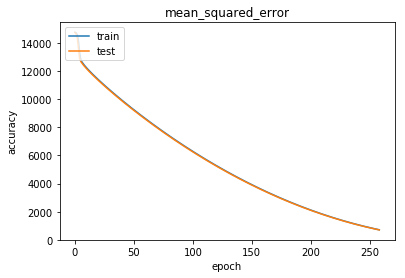

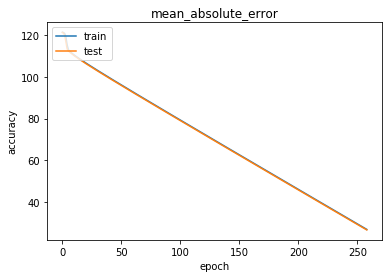

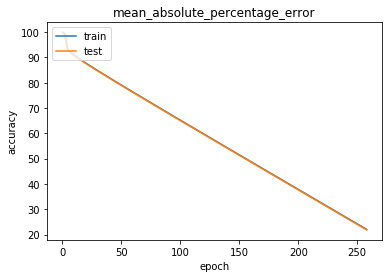

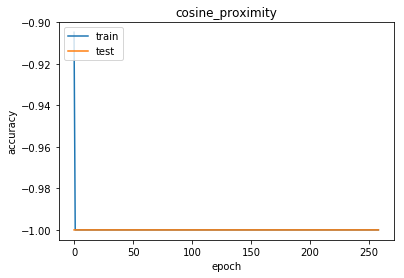

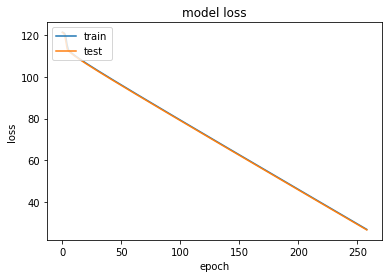

In [119]:

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('cosine_proximity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
